#### Preamble

In [2]:
# TODO: Import necessary libraries
import torch
from torchvision import transforms
from torchvision import datasets
from torch import nn
import numpy as np
from sklearn.metrics import f1_score  


# 8.2 Using different Optimizers

In this exercise you get to use your previously built networks, but this time we will play around with different optimizers and have a brief introduction to schedulers (Bonus)

### 8.2.1 AdaGrad, Adam, SGD

In this exercise reuse your deep regularized network from Assignment 7 (using `torch`) and train your model with different optimizers, namely AdaGrad, Adam, and SGD. (**1 point**)

Report your accuracy and $F_1 score$ matrices for training and test set. Do you see any difference in the matrices with rergards to number of epochs? (**0.5 point**)

Plot the values of your training loss for all three optimizers. Does your observation of differences match what you expected? (**0.5 point**)

In another plot, visualize the weight update trajectories of your model when using different optimizers.

*You should keep in mind that while generating points for plotting, you should keep other hyperparameters constant. This provides you a better sense of performance comparison.*

In [51]:
class Model(nn.Module):
    """
    Implement a model that incorporates dropout and L2 regularization
    depending on arguments passed.
    
    Args:
    input_dim: dimensionality of the inputs
    hidden_dim: how many units each hidden layer will have
    out_dim: how many output units
    num_layers: how many hidden layers to create/use
    dropout: a list of booleans specifying which hidden layers will have dropout
    dropout_p: the probability used for the `Dropout` layers
    l2_reg: a boolean value that indicates whether L2 regularization should be used
    """
    # TODO: Implement
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 out_dim: int,
                 num_layers: int,
                 dropout: list,
                 dropout_p: float,
                 l2_reg: bool):

        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.dropout_list = dropout
        self.dropout_p = dropout_p
        self.l2_reg = l2_reg
        self.flatten = nn.Flatten()
        
        # Define the layers of the network
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc_out = nn.Linear(hidden_dim, out_dim)
        
        # Use the dropout layer if specified
        if self.dropout_p > 0.0:
            self.dropout = nn.Dropout(p=self.dropout_p)
            
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        
        i=0
        for layer in self.hidden_layers:
            x = layer(x)
            x = torch.relu(x)   
            if self.dropout_p > 0.0 and self.dropout_list[i]:
                x = self.dropout(x)
                
            i+=1
        
        x = self.fc_out(x)

        return x
    
def train(dataloader, model, loss_fn, optimizer, lambda_l2):
    losses = list()
    # Total size of dataset for reference
    size = 0

    # places your model into training mode
    model.train()

    correct = 0
    _correct = 0
    
    y_true = torch.tensor(()).to(device)
    y_pred = torch.tensor(()).to(device)

    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):

        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)

        # Compute prediction error / loss
        # 1. Compute y_pred 
        # 2. Compute loss between y and y_pred using selectd loss function

        pred = model.forward(X)
        loss = loss_fn(pred, y)
        
        y_true = torch.cat((y_true, y), 0)
        y_pred = torch.cat((y_pred, pred.argmax(1)), 0)
     
    
        # L2 regularization
        if model.l2_reg:
            l2=0
            for p in model.parameters():
                l2 = l2 + (p**2).sum()
                loss = loss + lambda_l2 * l2

        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0 
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)

        correct += _correct


        size += _batch_size

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(float(loss))
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    correct/=size
    correct*=100
    print(f"Train : \nAccuracy: {(correct):>0.1f}%")

    f1 = f1_score(y_true.cpu(), y_pred.cpu(), average='macro') * 100
    print(f"F1 score: {(f1):>0.1f}%")

    return losses, f1, correct

def validation(dataloader, model, loss_fn):

    # Total size of dataset for reference
    size = 0

    # Setting the model under evaluation mode.
    model.eval()

    test_loss = 0
    correct = 0
    _correct = 0
    _batch_size = 0
    
    y_true = torch.tensor(()).to(device)
    y_pred = torch.tensor(()).to(device)

    with torch.no_grad():

        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model.forward(X)
            
            y_true = torch.cat((y_true, y), 0)
            y_pred = torch.cat((y_pred, pred.argmax(1)), 0)

            loss_fn(pred, y).item()
            _batch_size = len(X)

            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct

            size+=_batch_size


    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size
    
    ## calculating f1 score
    f1 = f1_score(y_true.cpu(), y_pred.cpu(), average='macro')

    print(f"Validation : \nAccuracy: {(100*correct):>0.1f}%")
    print(f"F1 score: {(100*f1):>0.1f}%")
    print()
    return f1*100, correct*100

In [52]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT FOR THE BATCH SIZE IF NECESSARY
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_fn)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_fn)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

# Use the above data for your experiments

In [67]:
# TODO: Run your experiments

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

learning_rate = 0.01
loss_function = nn.CrossEntropyLoss()
hidden_dim = 512
dropout_p = 0.5
inp = 28*28
out = 10
lambda_l2 = 0.001
epochs = 5

initial_arr = [True, False]
arr = np.random.choice(initial_arr, size=hidden_dim)
bool_list = list(map(bool, arr))

Using cpu device


In [68]:
sgd = torch.optim.SGD

adagrad = torch.optim.Adagrad

adam = torch.optim.Adam

optimizers = [
    sgd, adagrad, adam
]

results = {}

for opt in optimizers:
  model = Model(inp, hidden_dim, out, 1, bool_list, 0, l2_reg = False).to(device) # reset model
  optimizer = opt(model.parameters(), lr=learning_rate)
  losses = list()
  print("Model Running \n")
  for t in range(epochs):
      # print(f"Epoch {t+1}\n-------------------------------")
      loss, f1_train, acc_train = train(train_dl, model, loss_function, optimizer, lambda_l2)
      losses.extend(loss)
      f1, acc = validation(test_dl, model, loss_function)
  
  results[opt] = {'loss': losses, 'f1': f1, 'acc': acc, 'f1_train': f1_train, 'acc_train': acc_train}
  print("Done!")

Model Running 

loss: 2.320999  [    0]
loss: 2.276077  [  320]
loss: 2.300653  [  640]
loss: 2.252030  [  960]
loss: 2.206856  [ 1280]
loss: 2.222241  [ 1600]
loss: 2.127181  [ 1920]
loss: 2.104581  [ 2240]
loss: 2.126758  [ 2560]
loss: 2.088858  [ 2880]
loss: 2.162290  [ 3200]
loss: 2.076924  [ 3520]
loss: 2.126483  [ 3840]
loss: 2.052465  [ 4160]
loss: 1.934032  [ 4480]
loss: 2.040320  [ 4800]
loss: 1.944318  [ 5120]
loss: 1.889231  [ 5440]
loss: 1.922754  [ 5760]
loss: 1.848695  [ 6080]
loss: 1.784277  [ 6400]
loss: 1.797436  [ 6720]
loss: 1.726682  [ 7040]
loss: 1.591410  [ 7360]
loss: 1.516301  [ 7680]
loss: 1.562369  [ 8000]
loss: 1.447113  [ 8320]
loss: 1.547152  [ 8640]
loss: 1.407163  [ 8960]
loss: 1.240997  [ 9280]
loss: 1.309970  [ 9600]
loss: 1.196486  [ 9920]
loss: 0.996139  [10240]
loss: 1.136871  [10560]
loss: 1.317883  [10880]
loss: 1.045356  [11200]
loss: 0.918555  [11520]
loss: 0.989319  [11840]
loss: 0.905401  [12160]
loss: 0.933554  [12480]
loss: 0.966700  [12800]


1 Epoch

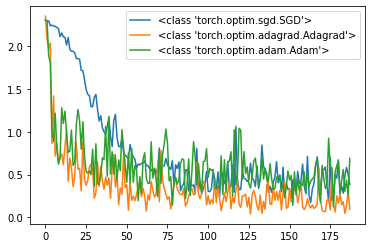

In [55]:
import matplotlib.pyplot as plt

x = range(len(losses))

for k, v in results.items():
  plt.plot(x, v['loss'], label=k)

plt.legend()

10 Epoch

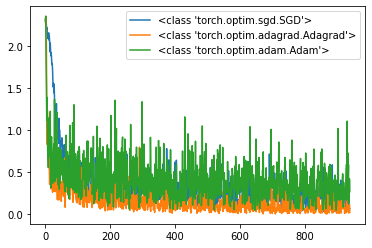

In [69]:
import matplotlib.pyplot as plt

x = range(len(losses))

for k, v in results.items():
  plt.plot(x, v['loss'], label=k)

plt.legend()

1 epoch

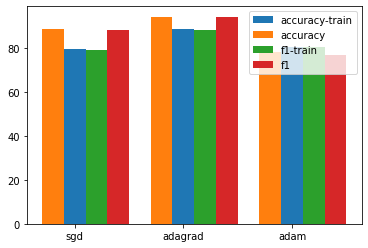

In [66]:
x = np.arange(3)
width = 0.2

fig, ax = plt.subplots()

f1s = list()
accs = list()
f1_train = list()
acc_train = list()

for opt in results:
  accs.append(results[opt]['acc'])
  f1s.append(results[opt]['f1'])
  f1_train.append(results[opt]['f1_train'])
  acc_train.append(results[opt]['acc_train'])


plt.bar(x, acc_train, width)
plt.bar(x-0.2, accs, width)
plt.bar(x+0.2, f1_train, width)
plt.bar(x+0.4, f1s, width)
plt.xticks(x, ['sgd', 'adagrad', 'adam'])
plt.legend(['accuracy-train', 'accuracy', 'f1-train', 'f1'])

10 Epoch

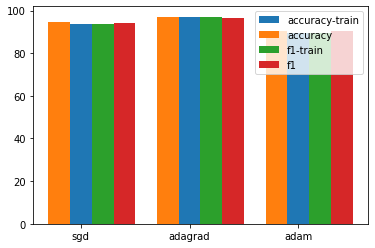

In [70]:
x = np.arange(3)
width = 0.2

fig, ax = plt.subplots()

f1s = list()
accs = list()
f1_train = list()
acc_train = list()

for opt in results:
  accs.append(results[opt]['acc'])
  f1s.append(results[opt]['f1'])
  f1_train.append(results[opt]['f1_train'])
  acc_train.append(results[opt]['acc_train'])


plt.bar(x, acc_train, width)
plt.bar(x-0.2, accs, width)
plt.bar(x+0.2, f1_train, width)
plt.bar(x+0.4, f1s, width)
plt.xticks(x, ['sgd', 'adagrad', 'adam'])
plt.legend(['accuracy-train', 'accuracy', 'f1-train', 'f1'])

Result: 
Metrices gets high as epoch number increases


### 8.2.2 Schedulers (1 point) (**Bonus**)

In `torch.optim` module, we have a functionality called `scheduler` https://pytorch.org/docs/stable/optim.html & in several different flavour of schedulers i.e. in Pytorch Ignite and HuggingFace, we have a functionality called `warmup_steps`. Briefly explain why would we need to use a scheduler with warmup steps.

Warmup steps are some steps that we do before starting the training of the model. In these steps we use really low learning rate. Warmup steps believed to have some benefits but in this context, optimizers may need previous steps to work properly, such as rmsprop. In this case, using warmup steps will prevent some optimizers to make a bad training at the cold start. Scheduler will provide functionality of changing learning rate. 